In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Explicit scheme

In [36]:
Nx = 100
#dx = 1/(Nx-1)
Nt = 100
#dt = 1/(Nt-1) 
x = np.linspace(-10,10,Nx)
dx = x[1] - x[0]
t = np.linspace(0,10,Nt)
dt= t[1] - t[0]
sol = np.ones((Nt,Nx), dtype = np.double)

sol[0] = np.exp(-(x-4)**2) + np.exp(-(x+4)**2) 
sol[:,0] = 0
sol[:,-1] = 0
#source = 0.5*x**2
source = np.zeros(Nx,dtype = np.double)
c = dt/(dx**2)
print(dt - dx**2 / 4) # Checking stability
print(dt)

0.09080706050403016
0.10101010101010101


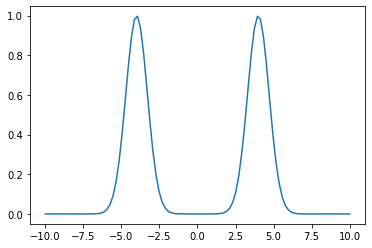

In [37]:
plt.plot(x,sol[0]) # Initial condition
plt.show()

In [38]:
for i in range(Nt-1):
    sol[i+1,1:-1] = sol[i,1:-1]+c*( sol[i,2:] + sol[i,:-2] -2*sol[i,1:-1]) + dt* source[1:-1] 

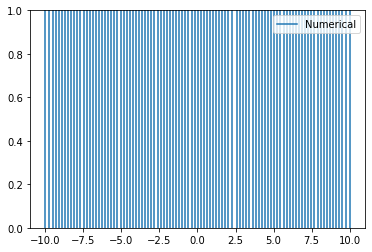

In [39]:
#for i in range(0,Nt-1,1000):
plt.plot(x,sol[-1], label = "Numerical")
plt.ylim(0,1)
#fullsol = 1/np.sqrt(5)*np.exp(-1*(x**2 / 5))
#plt.plot(x,fullsol,'--',label = 'Correct')
plt.legend()
plt.show()

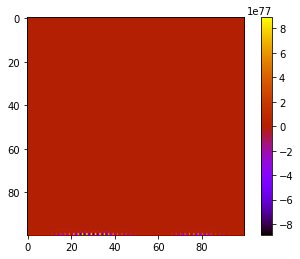

In [40]:
plt.imshow(sol[::max(int(Nt/Nx),1)], cmap = 'gnuplot')
plt.colorbar()
plt.show()

# Implicit Scheme

In [3]:
def zipper( A , b):
    N = np.shape(A)[0]
    assert A.shape[0] == A.shape[1] == b.shape[0]
    sol = np.ones(N)
    sol[0] = 0
    sol[-1] = 0
    alpha = np.zeros(N-1, dtype = np.float64)
    beta = np.copy(alpha)
    
    alpha[N-2] = 0   
    beta[N-2] = sol[-1] # Initial Values
    for i in range(2,N+1):
        c = -1/(A[N-i,N-i]+ alpha[N-i]*A[N-(i+1),N-i] )
        beta[N-(i+1)] = c*(A[N-(i+1),N-i]*beta[N-i]-b[N-i])
        alpha[N-(i+1)] = c*A[N-(i-1),N-i]
    for i in range(0,N-2):
        sol[i+1] = alpha[i]*sol[i]+beta[i]
    return sol

In [4]:
%load_ext cython

In [5]:
%%cython
cimport cython
import numpy as np
cimport numpy as np
np.import_array()
#@cython.boundscheck(False) #unstable, causes random kernel crashes
#@cython.wraparound(False)  # Same, probably 
def zipperc( double[:,:] A , double[:] b, int N , int sol0 , int solN):
    
    sol = np.zeros(N, dtype = np.double)
    cdef double[:] sol_view = sol
    sol_view[0] = sol0
    sol_view[N-1] = solN
    alpha = np.zeros(N-1, dtype = np.double)
    cdef double[:] alpha_view = alpha
    beta = np.zeros(N-1, dtype = np.double)
    cdef double[:] beta_view = beta
    cdef double c
    
    cdef np.npy_intp i,j
    alpha_view[N-2] = 0.0
    beta_view[N-2] = solN 
    for i in range(2,N+1):
        c = -1/(A[N-i,N-i]+ alpha_view[N-i] * A[N-(i+1),N-i] )
        beta_view[N-(i+1)] = c*(A[N-(i+1),N-i]*beta_view[N-i]-b[N-i])
        alpha_view[N-(i+1)] = c*A[N-(i-1),N-i]
    for j in range(0,N-2):
        sol_view[j+1] = alpha_view[j]*sol_view[j]+beta_view[j]
    return sol

In [41]:
A = np.diag(np.ones(Nx,dtype = np.double))*(1 + 2*dt/dx**2) + np.diag(np.ones(Nx-1,dtype = np.double),1)*(-1*dt/dx**2) +  np.diag(np.ones(Nx-1,dtype = np.double),-1)*(-1*dt/dx**2)
sol = np.ones((Nt,Nx))
sol[0] = np.exp(-(x-4)**2) + np.exp(-(x+4)**2) 
sol[:,0] = 0.0
sol[:,-1] = 0.0
source = np.zeros(Nx)
for i in range(Nt-1):
    sol[i+1,:] = zipperc(A, sol[i]+ source*dt,Nx,0,0)
    
print("DONE")

DONE


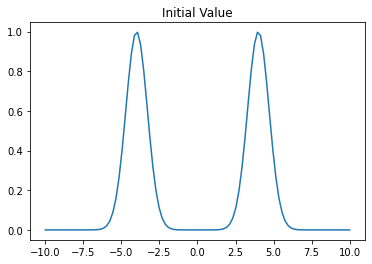

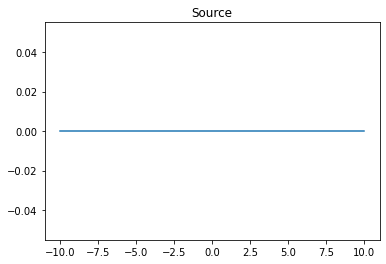

In [42]:
plt.plot(x,sol[0])
plt.title("Initial Value")
plt.show()
plt.plot(x,source)
plt.title("Source")
plt.show()

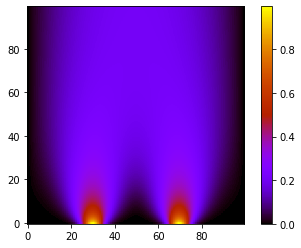

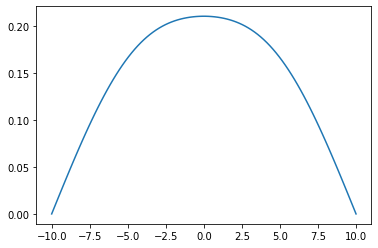

In [43]:
plt.imshow(sol[::max(int(Nt/Nx),1)],cmap ='gnuplot',origin = 'lower')
plt.colorbar()
plt.show()
plt.plot(x,sol[-1])
plt.show()

0.9391174050700313

In [19]:
%timeit zipperc(A,source*dt,Nx,0,0)

11.4 µs ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [64]:
%timeit zipper(A,source*dt)

325 µs ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# 2D Implicit

In [44]:
Nx = 100
Ny = 100
Nt = 100
t = np.linspace(0,5,Nt)
x = np.linspace(-5,5,Nx)
y = np.linspace(-5,5,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]

XX,YY = np.meshgrid(x,y)

sol = np.ones((Nt,Nx,Ny), dtype = np.double)

source = 0*XX + 0*YY
sol[0] = np.exp(-0.2*(XX**2 + YY**2))*np.sin(0.1*(XX**2 + YY**2))
    
sol[:,0,:] = 0
sol[:,-1,:] = 0
sol[:,:,0] = 0
sol[:,:,-1] = 0

inter = np.copy(sol)

Ax = np.diag(np.ones(Nx,dtype = np.double))*(1 + 2*dt/dx**2) + np.diag(np.ones(Nx-1,dtype = np.double),1)*(-1*dt/dx**2) +  np.diag(np.ones(Nx-1,dtype = np.double),-1)*(-1*dt/dx**2)
Ay = np.diag(np.ones(Ny,dtype = np.double))*(1 + 2*dt/dy**2) + np.diag(np.ones(Ny-1,dtype = np.double),1)*(-1*dt/dy**2) +  np.diag(np.ones(Ny-1,dtype = np.double),-1)*(-1*dt/dy**2)


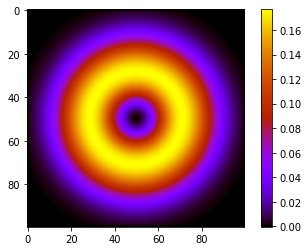

In [45]:
plt.imshow(sol[0], cmap ='gnuplot') #Initial condition
plt.colorbar()
plt.show()

In [46]:
for k in range(Nt-1):
    for i in range(Nx):
        sol[k+1,:,i] = zipperc(Ax,sol[k,:,i],Nx,0,0)
    for j in range(Ny):
        sol[k+1,j,:] = zipperc(Ay,sol[k+1,j,:],Ny,0,0)

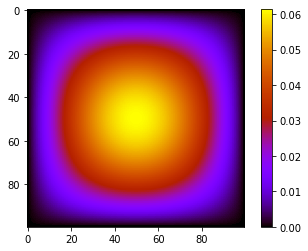

In [47]:
plt.imshow(sol[-1], cmap ='gnuplot')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


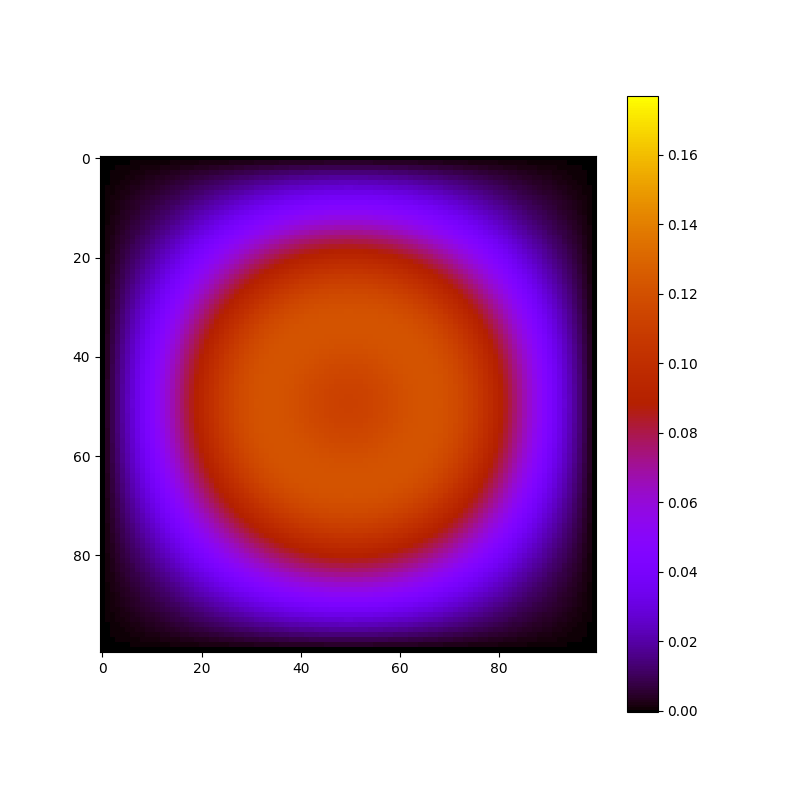

In [48]:
%matplotlib notebook
import matplotlib.animation as animation

fps = 30
nSeconds = 3


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = sol[0]
im = plt.imshow(a, cmap = 'gnuplot')

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(sol[i])
    return [im]

anim = animation.FuncAnimation(fig,animate_func,frames = nSeconds * fps, interval = 1000 / fps)
plt.colorbar()
#anim.save('2Ddifusion.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
plt.show()